In [1]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

#  Generate Data


## Training/Testing Data 

#### Create Data (Affine Transformation)

In [2]:
num_pts = 200
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy

In [3]:
## generate random points within the input polygon
def random_points_within(pol, num_points):
    min_x, min_y, max_x, max_y = pol.bounds

    gen_points = []

    while len(gen_points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if random_point.within(pol):
            gen_points.append(random_point)

    return gen_points

points_obj = random_points_within(poly, num_pts)
x = np.ones((3, num_pts))     #(x,y,b)

for i in range(num_pts):
    x[0][i] = points_obj[i].x
    x[1][i] = points_obj[i].y


In [4]:
## rotate input points in-place by pi/4 radian
transform1 = np.array([[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]])  # transformation matrix 1
transform2 = np.array([[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]])  # transformation matrix 2
rotate = np.array([[cos(pi / 4), -sin(pi / 4), 0], [sin(pi / 4), cos(pi / 4), 0], [0, 0, 1]])  # rotation matrix
y = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x)

#### Safe Bound

In [5]:
inp = np.array([[1.25, 3.75, 3.75, 1.25],[1.25, 1.25, 3.75, 3.75],[1, 1 , 1, 1]])
out = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), inp)
poly3 = Polygon([(out[0, 0], out[1, 0]), (out[0, 1], out[1, 1]), (out[0, 2], out[1, 2]), (out[0, 3], out[1, 3])])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]
b = -eqs[0:eqs.shape[0],-1]
print(A)
print(b)
print(ex_points)

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
[ 1.25        4.78553391 -2.28553391  1.25      ]
[[2.5        0.73223305]
 [4.26776695 2.5       ]
 [2.5        4.26776695]
 [0.73223305 2.5       ]
 [2.5        0.73223305]]


#### Plot the Genarated Data 

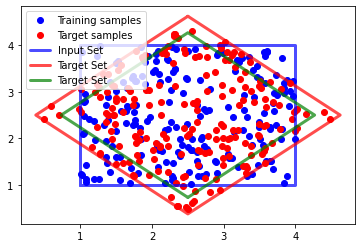

In [6]:
## plot generated data
x_poly3, y_poly3 = poly3.exterior.xy
plt.plot(x[0, :], x[1, :], 'bo', label='Training samples')
plt.plot(y[0, :], y[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()

## reshape input and outputs into column vectors
#x = np.transpose(x[[0, 1], :])
#y = np.transpose(y[[0, 1], :])
x = np.transpose(x)
y = np.transpose(y)

#### Generate data points around the edge

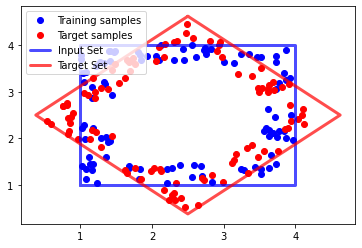

In [7]:
def random_points_edge(poly, num_points, scale = 0.7):
    poly_a = affinity.scale(poly, xfact = scale, yfact = scale)
    gen_points = []
    while len(gen_points) < num_points:
        temp = random_points_within(poly, 1)
        if not temp[0].within(poly_a):
            gen_points.append(temp[0])
    return gen_points

num_points_edge = 100
points_edge = random_points_edge(poly, num_points_edge)
x_edge = np.ones((3, num_points_edge))     #(x,y,b)

for i in range(num_points_edge):
    x_edge[0][i] = points_edge[i].x
    x_edge[1][i] = points_edge[i].y

## rotate input points in-place by pi/4 radian
y_edge = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x_edge)
    
## plot generated data
plt.plot(x_edge[0, :], x_edge[1, :], 'bo', label='Training samples')
plt.plot(y_edge[0, :], y_edge[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()
x_edge = np.transpose(x_edge)
y_edge = np.transpose(y_edge)

In [8]:
x = np.append(x, x_edge,axis = 0)
y = np.append(y, y_edge,axis = 0)

#### Training Mini-Batch Generator

In [9]:
print(x.shape)

(300, 3)


In [10]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset, :], self.Y[train_dataset, :], self.X[test_dataset, :], self.Y[test_dataset, :]
num_pts = x.shape[0]
batch_size = int(0.7 * num_pts)
batch = Batch(x, y, batch_size)

In [11]:
batch_size

210

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

![NN_original.jpg](NN_original.jpg)


#### Initializing Parameters for MLP Model

In [19]:
num_input = batch.X.shape[1]
num_output = batch.Y.shape[1]
#num_layers_0 = 3
num_hidden_0 = 3
num_hidden_1 = 3
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]
starter_learning_rate = 0.01
regularizer_rate = 0.001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(3,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))

model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 3)                 12        
_________________________________________________________________
layer1 (Dense)               (None, 3)                 12        
_________________________________________________________________
output (Dense)               (None, 3)                 12        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.28870797, -0.48251033, -0.80308104],
       [-0.3256371 ,  0.92246985, -0.04437065],
       [ 0.8106642 ,  0.68010783, -0.7059972 ]], dtype=float32)>, <tf.Variable 'layer0/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]
<tf.Variable 'layer0/kernel:0' shape=(3, 3) dtype=float32, nump

#### Train the model

In [20]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = loss,
                   metrics=['accuracy'])

In [21]:
x_train, y_train, x_test, y_test = batch.getBatch()
his = model_orig.fit(x_train, y_train, epochs=300, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


Model Accuracy on Test Data Set
3/3 - 0s - loss: 0.0146 - accuracy: 1.0000


[0.014583395794034004, 1.0]

In [22]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()

In [23]:
weights = []
bias = []

for iterate in model_orig.layers:
    print(iterate.output_shape)
    weights.append(iterate.kernel.numpy())
    bias.append(iterate.bias.numpy())





(None, 3)
(None, 3)
(None, 3)


#### Plot Loss Function

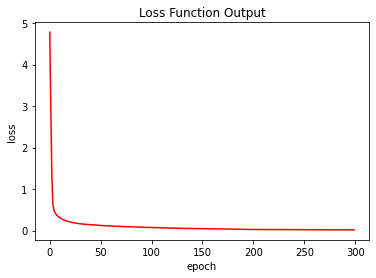

In [24]:

results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Plot Trained Model Ouput

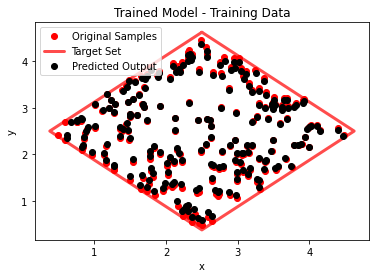

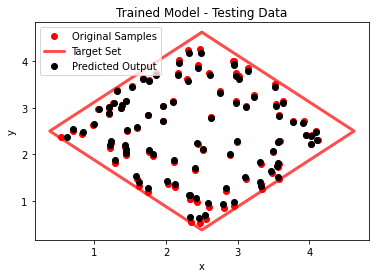

In [25]:
def plot_model(model, x_true, y_true, poly_1, poly_2, arg):
    y_predict = model_orig.predict(x_true)
    
    ## training output
    plt.plot(y_true[:, 0], y_true[:, 1], 'ro', label='Original Samples')
    x_poly_2, y_poly_2 = poly_2.exterior.xy
    plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2,
             label='Target Set')

    ## predicted output
    plt.plot(y_predict[:, 0], y_predict[:, 1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, poly, poly2, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, poly, poly2, arg='Trained Model - Testing Data')

In [26]:
## save data
# import pickle 
# pickle.dump(x_train,open("x_train.dat","wb"))
# pickle.dump(y_predict_train,open("y_predict_train.dat","wb"))
# pickle.dump(y_train,open("y_train.dat","wb"))
# pickle.dump(w_0,open("w_0.dat","wb"))
# pickle.dump(b_0,open("b_0.dat","wb"))
# pickle.dump(w_1,open("w_1.dat","wb"))
# pickle.dump(b_1,open("b_1.dat","wb"))

### Replicate the Original NN

#### Classes (NN with Numpy)

In [27]:
class Dense:
    def __init__(self, nin, nout):
        self.weights = np.random.rand(nin, nout) * 2 - 1
        self.bias = np.random.rand(nout) * 2 - 1
        
    def _relu(self, x):
        return np.maximum(x, 0)
    
    def __call__(self, x, relu=False):
        x = x @ self.weights + self.bias
        if relu:
            x = self._relu(x)
            
        return x

    def set_variables(self, weights=None, bias=None):
        if weights is not None:
            self.weights[:] = weights[:]
            
        if bias is not None:
            self.bias[:] = bias[:]
            
class MLP:
    def __init__(self, nin, uout, uhidden):
        self.num_layer = len(uhidden)+1
        prev = nin
        self.layers = []
        for u in uhidden:
            self.layers.append(Dense(prev, u))
            prev = u
        self.layers.append(Dense(prev, uout))
        
    def __call__(self, x, relu=False):
        
        if self.num_layer == 2:
            x1 = self.layers[0](x, relu=True)
            y = self.layers[1](x1, relu=relu)
            return x1, y
        
        if self.num_layer == 3:
            x1 = self.layers[0](x, relu=True)
            x2 = self.layers[1](x1, relu=True)
            y = self.layers[2](x2, relu=relu)
            print(x.shape)
            print(x1.shape)
            print(x2.shape)
            print(y.shape)
            return x1, x2, y

#### Reconstruct the Original NN to Obtain Diferrent Layer values given Input x0

In [28]:
mlp_orig = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_orig.layers[0].weights=w0_orig   
mlp_orig.layers[1].weights=w1_orig  
mlp_orig.layers[2].weights=w2_orig  
mlp_orig.layers[0].bias=b0_orig
mlp_orig.layers[1].bias=b1_orig
mlp_orig.layers[2].bias=b2_orig

X0_orig_train, X1_orig_train, Y_orig_train = mlp_orig(x_train, relu=False)
X0_orig_test, X1_orig_test, Y_orig_test = mlp_orig(x_test, relu=False)


# print("w0= "+str(w_0))
# print("w1= "+str(w_1))
# print("b0= "+str(b_0))
# print("b1= "+str(b_1))
# print("x_train= "+str(x_train))
# print("hiddel_layer= "+str(h_copy))
# print("y_predicted= "+str(y_copy))
#print(y_predict_train)
#print(Y_orig_train)

(210, 3)
(210, 3)
(210, 3)
(210, 3)
(90, 3)
(90, 3)
(90, 3)
(90, 3)


### Network Repair Class

#### classes

In [91]:
class MIPLayer:
    def __init__(self, model, layer_to_repair, uin, uout, weights, bias, param_bounds=(-1, 1)):

        model.nlayers = getattr(model, 'nlayers', 0)
        # print("Model layers = {}".format(model.nlayers))
        self.layer_num = model.nlayers
        self.uin, self.uout = uin, uout

        if model.nlayers == layer_to_repair:
            w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
            setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
            setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
            self.w = getattr(model, w_l)
            self.b = getattr(model, b_l)
            self.w_orig = weights
            self.b_orig = bias
        else:
            self.w = weights
            self.b = bias
            
        model.nlayers += 1

        self.model = model
        self.layer_to_repair = layer_to_repair
        
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1),w_b_bound_error=0.5):
        
        self.lout = getattr(self, 'layer_num', 0)+1
        # print("*****************")
        # print(self.lout)
        # print(self.layer_to_repair+1)
        # print("*****************")
        if relu:
            return self._relu_constraints(x, shape, self.lout, output_bounds, w_b_bound_error)
        return self._constraints(x, shape, self.lout, output_bounds, w_b_bound_error)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 0.5):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        w_l = 'w'+str(l-1)
        b_l = 'b'+str(l-1)

        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        # weight error bounding constraint
        if l==self.layer_to_repair+1:
            print("Activating mid layer")
            
            dw_l = 'dw' + str(l-1)
            setattr(self.model, dw_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0, output_bounds[1])))
            
            def constraint_bound_w0(model, i, j):
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= getattr(model, dw_l))
        
            def constraint_bound_w1(model, i, j): 
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -getattr(model, dw_l))
        
            def constraint_bound_b0(model, j):
                return(getattr(model, b_l)[j]-self.b_orig[j] <= getattr(model, dw_l))
        
            def constraint_bound_b1(model, j): 
                return(getattr(model, b_l)[j]-self.b_orig[j] >= -getattr(model, dw_l))
            
            setattr(self.model, 'w_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
            setattr(self.model, 'w_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
            setattr(self.model, 'b_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
            setattr(self.model, 'b_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 0.5):
        m, n = shape
        assert n == self.uin
        if l==self.layer_to_repair+1:
            w_l = 'w'+str(l-1)
            b_l = 'b'+str(l-1)
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        ################ Define outpur constraint here #######################
        def constraint_inside0(model, i):
             return(A[0,0]*getattr(model, x_l)[i, 0] + A[0,1]*getattr(model, x_l)[i, 1] - b[0] <= 0)
        
        def constraint_inside1(model, i):
             return(A[1,0]*getattr(model, x_l)[i, 0] + A[1,1]*getattr(model, x_l)[i, 1] - b[1] <= 0)
        
        def constraint_inside2(model, i):
             return(A[2,0]*getattr(model, x_l)[i, 0] + A[2,1]*getattr(model, x_l)[i, 1] - b[2] <= 0)
       
        def constraint_inside3(model, i):
             return(A[3,0]*getattr(model, x_l)[i, 0] + A[3,1]*getattr(model, x_l)[i, 1] - b[3] <= 0)

        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        setattr(self.model, 'keep_inside_constraint1'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside1))
        setattr(self.model, 'keep_inside_constraint2'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside2))
        setattr(self.model, 'keep_inside_constraint3'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside3))
        ############################### end #################################
        
        # weight error bounding constraint
        if l==self.layer_to_repair+1:
            print("Activating Last layer")
            
            dw_l = 'dw' + str(l-1)
            setattr(self.model, dw_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0, output_bounds[1])))
            
            def constraint_bound_w0(model, i, j):
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= getattr(model, dw_l))
        
            def constraint_bound_w1(model, i, j): 
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -getattr(model, dw_l))
        
            def constraint_bound_b0(model, j):
                return(getattr(model, b_l)[j]-self.b_orig[j] <= getattr(model, dw_l))
        
            def constraint_bound_b1(model, j): 
                return(getattr(model, b_l)[j]-self.b_orig[j] >= -getattr(model, dw_l))
            
            setattr(self.model, 'w_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
            setattr(self.model, 'w_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
            setattr(self.model, 'b_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
            setattr(self.model, 'b_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        
        
        return getattr(self.model, x_l)

In [40]:
class MIPNNModel:
    def __init__(self, layer_to_repair, architecture, weights, bias, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = layer_to_repair
        
        self.uin, self.uout = architecture[layer_to_repair-1], architecture[-1]
        uhidden = architecture[layer_to_repair:-1]
        
        self.layers = []
        prev = architecture[layer_to_repair-1]
        print("UHidden = {}".format(uhidden))
        for iterate, u in enumerate(uhidden): 
            self.layers.append(MIPLayer(self.model, layer_to_repair, prev, u, weights[layer_to_repair-1 + iterate], bias[layer_to_repair-1 + iterate], param_bounds))
            prev = u
        self.layers.append(MIPLayer(self.model, layer_to_repair, prev, architecture[-1], weights[-1], bias[-1], param_bounds))
        
        
    def __call__(self, x, shape, w_b_bound_error, relu=False, output_bounds=(-1e1, 1e1)):
        
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds, w_b_bound_error=w_b_bound_error)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds,w_b_bound_error=w_b_bound_error)
        return y

## Repair the network with the modification of the last layer

Repairing last layer $\mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y}$:

\begin{align}
       & \min_{\mathbf{W}^2,\mathbf{b}^2}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^2_n,\mathbf{W}^2,\mathbf{b}^2)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b.
\end{align}

![repair_last_layer.jpg](repair_last_layer.jpg)

#### Building 1 Layer

In [44]:
num_samples = X1_orig_train.shape[0]
layer_2_repair = 3
mip_model_layer3 = MIPNNModel(layer_2_repair, architecture, weights, bias)
y_ = mip_model_layer3(X1_orig_train, (num_samples, num_hidden_1), w_b_bound_error = 1)


model_lay3 = mip_model_layer3.model
pprint(vars(model_lay3))





UHidden = []
Activating Last layer
{'_constructed': True,
 '_ctype': <class 'pyomo.core.base.block.Block'>,
 '_ctypes': {<class 'pyomo.core.base.var.Var'>: [3, 22, 4],
             <class 'pyomo.core.base.set.Set'>: [0, 33, 22],
             <class 'pyomo.core.base.constraint.Constraint'>: [13, 34, 9]},
 '_data': {None: <pyomo.core.base.PyomoModel.ConcreteModel object at 0x138e11940>},
 '_decl': {'b3': 5,
           'b3_index': 4,
           'b_bounded_constraint04': 32,
           'b_bounded_constraint04_index': 31,
           'b_bounded_constraint14': 34,
           'b_bounded_constraint14_index': 33,
           'dw3': 22,
           'eq_constraint4': 13,
           'eq_constraint4_index': 12,
           'eq_constraint4_index_0': 10,
           'eq_constraint4_index_1': 11,
           'keep_inside_constraint04': 15,
           'keep_inside_constraint04_index': 14,
           'keep_inside_constraint14': 17,
           'keep_inside_constraint14_index': 16,
           'keep_inside_const

#### Final Output and Ojbective

In [45]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# minimize error bound
dw_l = 'dw' + str(layer_2_repair)

cost_expr += getattr(model_lay3, dw_l)



model_lay3.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay3)
opt = pyo.SolverFactory('gurobi',solver_io="python")

opt.solve(model_lay3, tee=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to /var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/tmpglc8doxa.log
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1494 rows, 643 columns and 4869 nonzeros
Model fingerprint: 0xba1a2e72
Coefficient statistics:
  Matrix range     [5e-02, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [9e-02, 5e+00]
Presolve removed 1004 rows and 582 columns
Presolve time: 0.01s
Presolved: 490 rows, 481 columns, 3860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5105659e-01   1.126025e+03   0.000000e+00      0s
      33    2.2283834e-01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.02 seconds
Optimal objective  2.228383414e-01
Changed value of parameter LogFile to 


{'Problem': [{'Name': 'unknown', 'Lower bound': 0.22283834142755746, 'Upper bound': 0.22283834142755746, 'Number of objectives': 1, 'Number of constraints': 1494, 'Number of variables': 643, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 643, 'Number of nonzeros': 4869, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.12', 'Status': 'ok', 'Wallclock time': 0.027265071868896484, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [56]:
model_lay3.w3.display()

w3 : Size=9, Index=w3_index
    Key    : Lower : Value                 : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :  -0.20601004438329462 :     1 : False : False :  Reals
    (0, 1) :    -1 : -0.022990302013642827 :     1 : False : False :  Reals
    (0, 2) :    -1 :    0.6344948105342316 :     1 : False : False :  Reals
    (1, 0) :    -1 :                   1.0 :     1 : False : False :  Reals
    (1, 1) :    -1 :   -0.2760952414977409 :     1 : False : False :  Reals
    (1, 2) :    -1 :  0.023640886711366216 :     1 : False : False :  Reals
    (2, 0) :    -1 :    0.2226684551531979 :     1 : False : False :  Reals
    (2, 1) :    -1 :    0.7770557029268441 :     1 : False : False :  Reals
    (2, 2) :    -1 :   -0.3173428095705437 :     1 : False : False :  Reals


In [48]:
model_lay3.b3.display()

b3 : Size=3, Index=b3_index
    Key : Lower : Value                : Upper : Fixed : Stale : Domain
      0 :    -1 :    0.571781753731482 :     1 : False : False :  Reals
      1 :    -1 : -0.18190908508229975 :     1 : False : False :  Reals
      2 :    -1 :  0.17477592902112726 :     1 : False : False :  Reals


In [49]:
print(w2_orig) #previously trained nn weights
print(b2_orig) #previously trained nn bias

[[-0.4288484  -0.24582864  0.41165647]
 [ 1.0912791  -0.4405214   0.24647923]
 [ 0.33317187  0.98019797 -0.09450447]]
[ 0.3489434  -0.40474743  0.39761427]


In [50]:
print(Y_orig_train)

[[1.47085159 2.5322154  0.92982776]
 [3.88508657 2.21573112 1.03647327]
 [3.08208182 3.61229361 1.10595271]
 [3.2986241  3.0589146  1.07284901]
 [2.11299213 1.4167697  0.87437642]
 [2.75599514 3.91083654 1.11233829]
 [3.90741212 3.10870955 1.11027485]
 [0.90633276 2.58837887 0.90344097]
 [2.0574029  1.94229282 0.91404086]
 [2.72023004 1.18585626 0.88890247]
 [3.78262008 2.20706937 1.03015123]
 [0.76311543 2.73382186 0.90740962]
 [2.30335297 0.92068035 0.8444935 ]
 [1.9859676  1.38027655 0.86444589]
 [1.48645812 3.57045943 1.01506753]
 [1.9113622  3.03955367 0.99521445]
 [1.62430573 3.2794237  0.9989713 ]
 [3.07339941 1.66533528 0.94723612]
 [0.83237506 2.15904669 0.8644917 ]
 [0.81232534 2.7851596  0.91428023]
 [2.96736817 1.87303618 0.95830368]
 [2.97797734 1.13046785 0.89853254]
 [3.15917345 3.47150685 1.09873695]
 [3.16853863 1.7064414  0.95579336]
 [2.36600573 4.08767458 1.10532855]
 [1.68061634 3.06257448 0.98443412]
 [1.23667898 3.17167728 0.96896127]
 [1.11509283 2.95053061 0.94

In [51]:
# model_lay3 = model_lay3_orig
y_new = np.zeros((num_samples, num_hidden_1))
w2_new = np.zeros((num_hidden_1, num_output))
b2_new = np.zeros((1, num_output))
for i in range(num_samples):
    for j in range(num_hidden_1):
        y_new[i, j] = model_lay3.x4[i, j].value
for j in range(num_output):
    b2_new[0, j] = model_lay3.b3[j].value
    for i in range(num_hidden_1):
        w2_new[i, j] = model_lay3.w3[i, j].value
print(w2_new)
print(b2_new)


[[-0.20601004 -0.0229903   0.63449481]
 [ 1.         -0.27609524  0.02364089]
 [ 0.22266846  0.7770557  -0.31734281]]
[[ 0.57178175 -0.18190909  0.17477593]]


#### Build Refined NN 

In [52]:
mlp_lay3 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay3.layers[0].weights=w0_orig   
mlp_lay3.layers[1].weights=w1_orig  
mlp_lay3.layers[2].weights=w2_new  
mlp_lay3.layers[0].bias=b0_orig
mlp_lay3.layers[1].bias=b1_orig
mlp_lay3.layers[2].bias=b2_new

_, _, y_new_train = mlp_lay3(x_train, relu=False)
_, _, y_new_test = mlp_lay3(x_test, relu=False)

(210, 3)
(210, 3)
(210, 3)
(210, 3)
(90, 3)
(90, 3)
(90, 3)
(90, 3)


#### Plot New Results

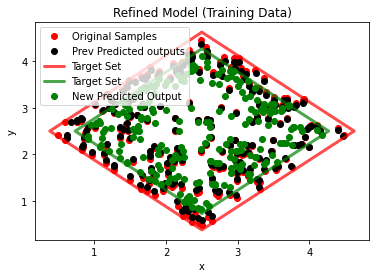

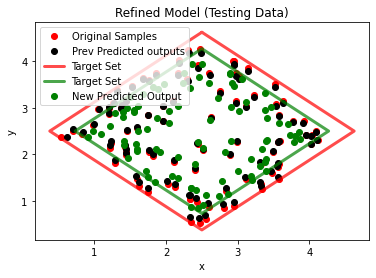

In [53]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_train[:, 0], y_new_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_test[:, 0], y_new_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [54]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Repaired NN (Last Layer)",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w2_new-w2_orig)
bias_error = np.linalg.norm(b2_new-b2_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00284,0.00276
Repaired NN (Last Layer),0.04707,0.04749


weight_error: 0.5806291913888971
bias_error: 0.38596732922691007


## Repair the network with the modification of the second layer

In the second layer:
$$
\mathbf{W}^1 \mathbf{X}^1 + \mathbf{b}^1 = \mathbf{H}^1,
$$
$$
\mathbf{X}^2 = \mathrm{ReLU} (\mathbf{H}^1),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^1,\mathbf{b}^1}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^1_n,\mathbf{W}^1,\mathbf{b}^1)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_second_layer.jpg](repair_second_layer.jpg)

### Replicate the Original NN

#### Classes (NN with Numpy)

In [57]:

num_samples = X1_orig_train.shape[0]
layer_2_repair = 2
mip_model_layer2 = MIPNNModel(layer_2_repair, architecture, weights, bias)
# y_ = mip_model_layer2(X1_orig_train, (num_samples, num_hidden_1))
y_ = mip_model_layer2(np.round(X0_orig_train,4), (num_samples, num_hidden_0), w_b_bound_error=1)

# print(y_)

model_lay2 = mip_model_layer2.model
pprint(vars(model_lay2))
#print(mip_model_layer3.model.eq_constraint1[(0,0)])





UHidden = [3]
Activating mid layer
{'_constructed': True,
 '_ctype': <class 'pyomo.core.base.block.Block'>,
 '_ctypes': {<class 'pyomo.core.base.var.Var'>: [3, 43, 7],
             <class 'pyomo.gdp.disjunct.Disjunct'>: [39, 39, 1],
             <class 'pyomo.gdp.disjunct.Disjunction'>: [38, 38, 1],
             <class 'pyomo.core.base.set.Set'>: [0, 54, 37],
             <class 'pyomo.core.base.constraint.Constraint'>: [21, 55, 10]},
 '_data': {None: <pyomo.core.base.PyomoModel.ConcreteModel object at 0x13a841900>},
 '_decl': {'b2': 5,
           'b2_index': 4,
           'b_bounded_constraint03': 32,
           'b_bounded_constraint03_index': 31,
           'b_bounded_constraint13': 34,
           'b_bounded_constraint13_index': 33,
           'disjunction3': 38,
           'disjunction3_disjuncts': 39,
           'disjunction3_index': 37,
           'disjunction3_index_0': 35,
           'disjunction3_index_1': 36,
           'dw2': 22,
           'eq_constraint3': 21,
           'e

#### Building the middle layer with the fixed weights for the final layer

In [58]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, np.round(y_train,4), num_samples, num_output) ## check correctness


#### Final Output and Ojbective

In [59]:


# minimize error bound
dw_l = 'dw' + str(layer_2_repair)

cost_expr += getattr(model_lay2, dw_l)



model_lay2.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay2)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 200
opt.options['mipgap'] = 0.04
opt.solve(model_lay2, tee=True)


Set parameter Username
Academic license - for non-commercial use only - expires 2022-02-04
Read LP format model from file /var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/tmp4_tdpyad.pyomo.lp
Reading time = 0.02 seconds
x3794: 6535 rows, 3794 columns, 14959 nonzeros
Set parameter TimeLimit to value 200
Set parameter MIPGap to value 0.04
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6535 rows, 3794 columns and 14959 nonzeros
Model fingerprint: 0x8bde8283
Variable types: 1904 continuous, 1890 integer (1890 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [9e-02, 1e+01]
Presolve removed 3788 rows and 1894 columns
Presolve time: 0.06s
Presolved: 2747 rows, 1900 columns, 8014 nonzeros
Variable types: 1480 continuous, 420 integer (420 binary)
Found heuristic solution: objective 0

{'Problem': [{'Name': 'x3794', 'Lower bound': 0.2397843669161187, 'Upper bound': 0.24139678665404946, 'Number of objectives': 1, 'Number of constraints': 6535, 'Number of variables': 3794, 'Number of binary variables': 1890, 'Number of integer variables': 1890, 'Number of continuous variables': 1904, 'Number of nonzeros': 14959, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.7478950023651123', 'Error rc': 0, 'Time': 1.137261152267456}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [60]:
model_lay2.w2.display()

w2 : Size=9, Index=w2_index
    Key    : Lower : Value                 : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 : -0.004229020220255064 :     1 : False : False :  Reals
    (0, 1) :    -1 :    0.7624490242361484 :     1 : False : False :  Reals
    (0, 2) :    -1 :    0.7634635440465334 :     1 : False : False :  Reals
    (1, 0) :    -1 :    0.2939534168600497 :     1 : False : False :  Reals
    (1, 1) :    -1 :    -0.424735885169645 :     1 : False : False :  Reals
    (1, 2) :    -1 :    0.5718825448064808 :     1 : False : False :  Reals
    (2, 0) :    -1 :      0.64173424243927 :     1 : False : False :  Reals
    (2, 1) :    -1 :   -0.5032309889793396 :     1 : False : False :  Reals
    (2, 2) :    -1 :   0.17888672649860382 :     1 : False : False :  Reals


In [61]:
model_lay2.b2.display()

b2 : Size=3, Index=b2_index
    Key : Lower : Value                : Upper : Fixed : Stale : Domain
      0 :    -1 : -0.15229094215636874 :     1 : False : False :  Reals
      1 :    -1 :    0.798714997255856 :     1 : False : False :  Reals
      2 :    -1 : -0.10918593219513273 :     1 : False : False :  Reals


In [62]:
print(w1_orig) #previously trained nn weights

[[-0.17665733  1.0038458   0.7425777 ]
 [ 0.5353502  -0.46492973  0.7287573 ]
 [ 0.64558005 -0.5070768   0.18273254]]


In [63]:
model_lay2.x4.display()

x4 : Size=630, Index=x4_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 : 1.6873784126814417 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 :  2.450490515776612 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 :  0.603371363645713 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 :  3.558720810576098 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 : 2.3581176999956943 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 0.7954993623389511 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 : 2.9076985736753294 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 3.5617583674609072 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.7344517726569078 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 : 3.0870887293503753 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 : 3.0765598892010786 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 0.7505144589287988 :  10.0 : False : False :  R

In [64]:
print(Y_orig_train)

[[1.47085159 2.5322154  0.92982776]
 [3.88508657 2.21573112 1.03647327]
 [3.08208182 3.61229361 1.10595271]
 [3.2986241  3.0589146  1.07284901]
 [2.11299213 1.4167697  0.87437642]
 [2.75599514 3.91083654 1.11233829]
 [3.90741212 3.10870955 1.11027485]
 [0.90633276 2.58837887 0.90344097]
 [2.0574029  1.94229282 0.91404086]
 [2.72023004 1.18585626 0.88890247]
 [3.78262008 2.20706937 1.03015123]
 [0.76311543 2.73382186 0.90740962]
 [2.30335297 0.92068035 0.8444935 ]
 [1.9859676  1.38027655 0.86444589]
 [1.48645812 3.57045943 1.01506753]
 [1.9113622  3.03955367 0.99521445]
 [1.62430573 3.2794237  0.9989713 ]
 [3.07339941 1.66533528 0.94723612]
 [0.83237506 2.15904669 0.8644917 ]
 [0.81232534 2.7851596  0.91428023]
 [2.96736817 1.87303618 0.95830368]
 [2.97797734 1.13046785 0.89853254]
 [3.15917345 3.47150685 1.09873695]
 [3.16853863 1.7064414  0.95579336]
 [2.36600573 4.08767458 1.10532855]
 [1.68061634 3.06257448 0.98443412]
 [1.23667898 3.17167728 0.96896127]
 [1.11509283 2.95053061 0.94

In [65]:
X2_new = np.zeros((num_samples,num_output))
w1_new = np.zeros((num_hidden_0,num_hidden_1))
b1_new = np.zeros((1,num_hidden_1))
for i in range(num_samples):
    for j in range(num_output):
        X2_new[i, j] = model_lay2.x4[i, j].value
for j in range(num_hidden_1):
    b1_new[0, j] = model_lay2.b2[j].value
    for i in range(num_hidden_0):
        w1_new[i, j] = model_lay2.w2[i, j].value
print(w1_new)
print(b1_new)

[[-0.00422902  0.76244902  0.76346354]
 [ 0.29395342 -0.42473589  0.57188254]
 [ 0.64173424 -0.50323099  0.17888673]]
[[-0.15229094  0.798715   -0.10918593]]


#### Build Refined NN


In [66]:
mlp_lay2 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay2.layers[0].weights=w0_orig   
mlp_lay2.layers[1].weights=w1_new  
mlp_lay2.layers[2].weights=w2_orig  
mlp_lay2.layers[0].bias=b0_orig
mlp_lay2.layers[1].bias=b1_new
mlp_lay2.layers[2].bias=b2_orig

_, _, y_new2_train = mlp_lay2(x_train, relu=False)
_, _, y_new2_test = mlp_lay2(x_test, relu=False)


(210, 3)
(210, 3)
(210, 3)
(210, 3)
(90, 3)
(90, 3)
(90, 3)
(90, 3)


#### Plot New Results


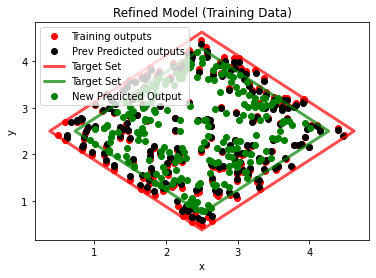

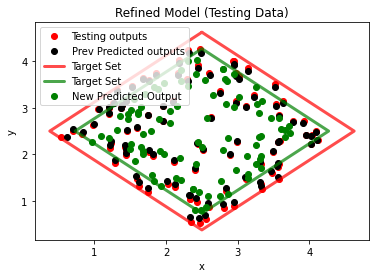

In [67]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Training outputs')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_train[:, 0], y_new2_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Testing outputs')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_test[:, 0], y_new2_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [68]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new2_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new2_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w1_new-w1_orig)
bias_error = np.linalg.norm(b1_new-b1_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00284,0.00276
Modified NN,0.06451,0.06576


weight_error: 0.41591125476153146
bias_error: 0.41811149926867824


## Repair the network with the modification of the first layer

In the first layer:
$$
\mathbf{W}^0 \mathbf{X}^0 + \mathbf{b}^0 = \mathbf{H}^0,
$$
$$
\mathbf{X}^1 = \mathrm{ReLU} (\mathbf{H}^0),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^0,\mathbf{b}^0}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{b}^0)-\mathbf{t}_n||^2_2, \\ \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\ \\
       & & & \sum_j w_{ij}^0 x_{jn}^0 + b_i^0 = x_{in}^1 - s_{in}^1, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^1, s_{in}^1 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=0 \rightarrow x_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=1 \rightarrow s_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\ \\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_first_layer.jpg](repair_first_layer.jpg)

### Replicate the Original NN

#### Classes (NN with Numpy)

#### Building the middle layer with the fixed weights for the final layer

In [80]:
num_samples = X1_orig_train.shape[0]
layer_2_repair = 1
mip_model_layer1 = MIPNNModel(layer_2_repair, architecture, weights, bias)
y_ = mip_model_layer1(np.round(x_train,4), (num_samples, num_input), w_b_bound_error=0.5)


model_lay1 = mip_model_layer1.model
pprint(vars(model_lay1))





UHidden = [3, 3]
Activating mid layer
{'_constructed': True,
 '_ctype': <class 'pyomo.core.base.block.Block'>,
 '_ctypes': {<class 'pyomo.core.base.var.Var'>: [3, 64, 10],
             <class 'pyomo.gdp.disjunct.Disjunct'>: [39, 60, 2],
             <class 'pyomo.gdp.disjunct.Disjunction'>: [38, 59, 2],
             <class 'pyomo.core.base.set.Set'>: [0, 75, 52],
             <class 'pyomo.core.base.constraint.Constraint'>: [21, 76, 11]},
 '_data': {None: <pyomo.core.base.PyomoModel.ConcreteModel object at 0x140986780>},
 '_decl': {'b1': 5,
           'b1_index': 4,
           'b_bounded_constraint02': 32,
           'b_bounded_constraint02_index': 31,
           'b_bounded_constraint12': 34,
           'b_bounded_constraint12_index': 33,
           'disjunction2': 38,
           'disjunction2_disjuncts': 39,
           'disjunction2_index': 37,
           'disjunction2_index_0': 35,
           'disjunction2_index_1': 36,
           'disjunction3': 59,
           'disjunction3_disjunct

#### Final Output and Ojbective

In [81]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, np.round(y_train,4), num_samples, num_output) ## check correctness

# minimize error bound
dw_l = 'dw' + str(layer_2_repair)

cost_expr += getattr(model_lay1, dw_l)



model_lay1.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay1)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 1000
opt.options['mipgap'] = 0.01
opt.solve(model_lay1, tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-02-04
Read LP format model from file /var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/tmpzmpn61me.pyomo.lp
Reading time = 0.03 seconds
x6944: 11575 rows, 6944 columns, 26299 nonzeros
Set parameter TimeLimit to value 1000
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11575 rows, 6944 columns and 26299 nonzeros
Model fingerprint: 0x0cac6ce7
Variable types: 3164 continuous, 3780 integer (3780 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [4e-02, 1e+01]
Presolve removed 6931 rows and 3151 columns
Presolve time: 0.06s
Presolved: 4644 rows, 3793 columns, 14328 nonzeros
Variable types: 2743 continuous, 1050 integer (1050 binary)
Found heuristic solution: objec

{'Problem': [{'Name': 'x6944', 'Lower bound': 0.14635789726931725, 'Upper bound': 0.14635789726931725, 'Number of objectives': 1, 'Number of constraints': 11575, 'Number of variables': 6944, 'Number of binary variables': 3780, 'Number of integer variables': 3780, 'Number of continuous variables': 3164, 'Number of nonzeros': 26299, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.3974771499633789', 'Error rc': 0, 'Time': 0.637376070022583}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [82]:
model_lay1.w1.display()

w1 : Size=9, Index=w1_index
    Key    : Lower : Value                : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :   0.5431633558396609 :     1 : False : False :  Reals
    (0, 1) :    -1 :    0.585612221900988 :     1 : False : False :  Reals
    (0, 2) :    -1 :  -0.9164081845160214 :     1 : False : False :  Reals
    (1, 0) :    -1 : -0.06682077484861204 :     1 : False : False :  Reals
    (1, 1) :    -1 :   0.7934219207886966 :     1 : False : False :  Reals
    (1, 2) :    -1 : -0.18890350644547615 :     1 : False : False :  Reals
    (2, 0) :    -1 :                  1.0 :     1 : False : False :  Reals
    (2, 1) :    -1 :    0.348795357691833 :     1 : False : False :  Reals
    (2, 2) :    -1 :  -0.8233171138640133 :     1 : False : False :  Reals


In [83]:
model_lay1.b1.display()

b1 : Size=3, Index=b1_index
    Key : Lower : Value                : Upper : Fixed : Stale : Domain
      0 :    -1 :  0.22495254761197447 :     1 : False : False :  Reals
      1 :    -1 :  -0.3033390905980381 :     1 : False : False :  Reals
      2 :    -1 : -0.14635789726931725 :     1 : False : False :  Reals


In [84]:
print(w1_orig) #previously trained nn weights

[[-0.17665733  1.0038458   0.7425777 ]
 [ 0.5353502  -0.46492973  0.7287573 ]
 [ 0.64558005 -0.5070768   0.18273254]]


In [85]:
model_lay1.x4.display()

x4 : Size=630, Index=x4_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 : 1.7976687621984766 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 : 2.5070440078241303 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 0.9457007136426154 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 : 3.4564339558710726 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 :  2.320425082113549 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 1.0214801269447646 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 : 2.8958452127545318 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 3.5775754877195514 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 1.0929199618761376 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 :   3.04817081536556 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 : 3.0749565596835504 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0604209485945182 :  10.0 : False : False :  R

In [86]:
print(Y_orig_train)

[[1.47085159 2.5322154  0.92982776]
 [3.88508657 2.21573112 1.03647327]
 [3.08208182 3.61229361 1.10595271]
 [3.2986241  3.0589146  1.07284901]
 [2.11299213 1.4167697  0.87437642]
 [2.75599514 3.91083654 1.11233829]
 [3.90741212 3.10870955 1.11027485]
 [0.90633276 2.58837887 0.90344097]
 [2.0574029  1.94229282 0.91404086]
 [2.72023004 1.18585626 0.88890247]
 [3.78262008 2.20706937 1.03015123]
 [0.76311543 2.73382186 0.90740962]
 [2.30335297 0.92068035 0.8444935 ]
 [1.9859676  1.38027655 0.86444589]
 [1.48645812 3.57045943 1.01506753]
 [1.9113622  3.03955367 0.99521445]
 [1.62430573 3.2794237  0.9989713 ]
 [3.07339941 1.66533528 0.94723612]
 [0.83237506 2.15904669 0.8644917 ]
 [0.81232534 2.7851596  0.91428023]
 [2.96736817 1.87303618 0.95830368]
 [2.97797734 1.13046785 0.89853254]
 [3.15917345 3.47150685 1.09873695]
 [3.16853863 1.7064414  0.95579336]
 [2.36600573 4.08767458 1.10532855]
 [1.68061634 3.06257448 0.98443412]
 [1.23667898 3.17167728 0.96896127]
 [1.11509283 2.95053061 0.94

In [87]:
X3_new = np.zeros((num_samples,num_output))
w0_new = np.zeros((num_input,num_hidden_0))
b0_new = np.zeros((1,num_hidden_0))
for i in range(num_samples):
    for j in range(num_output):
        X3_new[i, j] = model_lay1.x4[i, j].value
for j in range(num_hidden_0):
    b0_new[0, j] = model_lay1.b1[j].value
    for i in range(num_input):
        w0_new[i, j] = model_lay1.w1[i, j].value
print(w0_new)
print(b0_new)

[[ 0.54316336  0.58561222 -0.91640818]
 [-0.06682077  0.79342192 -0.18890351]
 [ 1.          0.34879536 -0.82331711]]
[[ 0.22495255 -0.30333909 -0.1463579 ]]


#### Build Refined NN


In [88]:
mlp_lay1 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay1.layers[0].weights=w0_new   
mlp_lay1.layers[1].weights=w1_orig  
mlp_lay1.layers[2].weights=w2_orig  
mlp_lay1.layers[0].bias=b0_new
mlp_lay1.layers[1].bias=b1_orig
mlp_lay1.layers[2].bias=b2_orig

_, _, y_new1_train = mlp_lay1(x_train, relu=False)
_, _, y_new1_test = mlp_lay1(x_test, relu=False)


(210, 3)
(210, 3)
(210, 3)
(210, 3)
(90, 3)
(90, 3)
(90, 3)
(90, 3)


#### Plot New Results


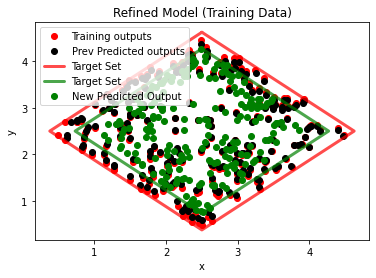

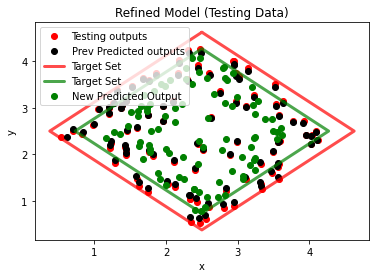

In [89]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Training outputs')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new1_train[:, 0], y_new1_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Testing outputs')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new1_test[:, 0], y_new1_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [90]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new1_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new1_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w0_new-w0_orig)
bias_error = np.linalg.norm(b0_new-b0_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))
print(w0_new-w0_orig)

MSE,Training Data,Testing Data
Original NN,0.00284,0.00276
Modified NN,0.09779,0.09944


weight_error: 0.37940898499874276
bias_error: 0.216418318049222
[[-0.1463579   0.03850733 -0.1463579 ]
 [ 0.10114957 -0.1463579  -0.1463579 ]
 [ 0.06093705  0.1463579  -0.1463579 ]]
